In [1]:
import tensorflow as tf
from keras import initializers, layers, models, optimizers, callbacks

import h5py
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Conv2D, Dense, Input, LSTM
from keras.layers.embeddings import Embedding

from capsule_layers import CapsuleLayer, PrimaryCap, Length

Using TensorFlow backend.


In [2]:
class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config

In [3]:
# training data
h5f = h5py.File('data.h5', 'r')
x = h5f['x'][:]
y = h5f['y'][:]
h5f.close()

print('x:', x.shape)
print('y:', y.shape)

x: (10000, 250, 250, 3)
y: (10000, 80)


In [4]:
split = 8000
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

In [5]:
with open('mapping.pickle', 'rb') as file:
    mapping = pickle.load(file)

cat_id = mapping['cat_id']
id_cat = mapping['id_cat']

Caption: person, bench, handbag, cake, dining table, 

Image:


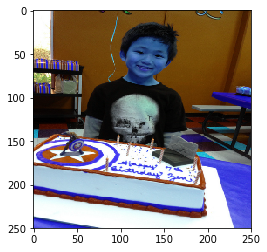

In [6]:
row_number = 1276
image_sample = x[row_number]
caption_idx = y[row_number]

caption_sample = ''
for idx in range(len(caption_idx)):
    if caption_idx[idx] == 1:
        caption_sample += id_cat[idx] + ', '

print('Caption:', caption_sample)
print('\nImage:')

plt.imshow(image_sample)
plt.show()

In [7]:
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = Conv2D(filters=96, kernel_size=13, strides=4, padding='valid', activation='relu', name='conv1')(x)
    conv2 = Conv2D(filters=96, kernel_size=5, strides=2, padding='valid', activation='relu', name='conv2')(conv1)
    conv3 = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv3')(conv2)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv3, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

In [8]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [9]:
def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args['save_dir'] + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args['save_dir'] + '/tensorboard-logs',
                               batch_size=args['batch_size'], histogram_freq=int(args['debug']))
    checkpoint = callbacks.ModelCheckpoint(args['save_dir'] + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args['lr'] * (args['lr_decay'] ** epoch))
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args['lr']),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args['lam_recon']],
                  metrics={'capsnet': 'accuracy'})

    # Training without data augmentation:
    model.fit(
        [x_train, y_train],
        [y_train, x_train],
        batch_size=args['batch_size'],
        epochs=args['epochs'],
        validation_data=[[x_test, y_test], [y_test, x_test]],
        callbacks=[log, tb, checkpoint, lr_decay, early_stop]
    )

    """
    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#
    """

    model.save_weights(args['save_dir'] + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args['save_dir'])

    from utils import plot_log
    plot_log(args['save_dir'] + '/log.csv', show=True)

    return model

In [ ]:
def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()

In [10]:
args= {}
args['save_dir'] = 'caps'
args['epochs'] = 20
args['batch_size'] = 100
args['lr'] = 0.001
args['lr_decay'] = 0.9
args['lam_recon'] = 0.392
args['routings'] = 3
args['shift_fraction'] = 0.1
args['debug'] = True

In [11]:
model, eval_model, manipulate_model = CapsNet(
    input_shape=x_train.shape[1:],
    n_class=len(y_train[0]),
    routings=args['routings']
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 96)   48768       input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 28, 28, 96)   230496      conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 20, 20, 256)  1990912     conv2[0][0]                      
__________________________________________________________________________________________________
primarycap

In [ ]:
model = train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
 800/8000 [==>...........................] - ETA: 43:27 - loss: 2.4178 - capsnet_loss: 2.3858 - decoder_loss: 0.0818 - capsnet_acc: 0.5725